In [9]:
from model import MyFasterRCNN
from data import BedsoreDataModule
from utils import batch2pil, draw_bbox, out2detfile
from matplotlib import pyplot as plt
import os
from PIL import Image
import numpy as np
import torch
from ensemble_boxes import *
import utils

In [2]:
dm = BedsoreDataModule(root='data', num_valid=100, batch_size=1, trans_prob=0.5)
ds = dm.test_dataloader().dataset

/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/pytorch/transforms.py:58: DeprecationWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0
  "ToTensor is deprecated and will be replaced by ToTensorV2 " "in albumentations 0.5.0", DeprecationWarning


B01_00128
gt: tensor([6])


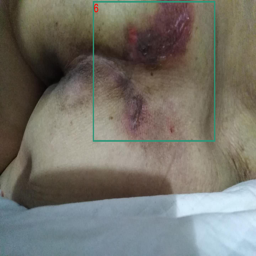

In [89]:
SZ = 256
idx = 32 # 22 25 32 49 93 95 97
image,target = ds[idx]
print(target['fname'])
print('gt:',target['labels'])
draw_bbox(image,target).resize((SZ,SZ))

out labels:  tensor([6, 6, 6, 6, 6, 2, 6])
out scores:  tensor([0.7788, 0.7433, 0.5367, 0.5193, 0.3433, 0.2230, 0.1503])
tensor([[ 591.6505,  294.2428,  978.2509,  601.6370],
        [ 522.7592,    0.0000, 1199.5721,  348.5140],
        [ 437.6316,    0.0000, 1173.1665,  615.4055],
        [ 637.0146,  356.0679,  914.4105,  566.6687],
        [ 509.0546,  235.2490, 1076.3275,  679.9752],
        [ 860.7360,  429.8195, 1043.0165,  622.0419],
        [ 651.2414,  379.4529, 1058.6912,  625.1971]], grad_fn=<StackBackward>)


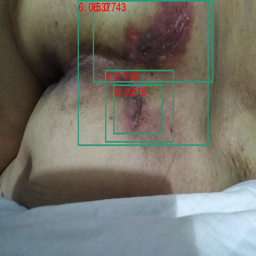

In [90]:
model = MyFasterRCNN.load_from_checkpoint('mlruns/3/f05e716e77b9480e986dd904487b5b3a/checkpoints/epoch=53.ckpt')
net = model.net
net.eval()
out = net([image],[target])[0]
print('out labels: ', out['labels'])
print('out scores: ', out['scores'].detach())
print(out['boxes'])
draw_bbox(image,out,th=0.5).resize((SZ,SZ))

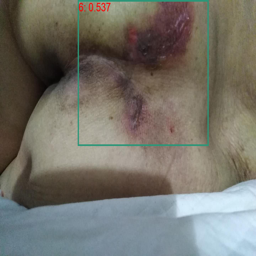

In [91]:
# 输入的是一个out，参数score_th=0.5，overlap_th>0.9
                    
out = utils.same_class_remove(out)
draw_bbox(image,out,th=0.5).resize((SZ,SZ))

### Batch Eval 计算分数

In [24]:
from model import MyFasterRCNN
from data import BedsoreDataModule, BedsoreLMDBDataModule
from utils import batch2pil, draw_bbox, out2detfile
from matplotlib import pyplot as plt
from tqdm import tqdm
import voc_eval
import os

detpath = 'temp/det_outs.txt'
imgsetfile = 'temp/evallist.txt'

In [27]:
dm = BedsoreDataModule(root='data', num_valid=100, batch_size=1,trans_prob=0.5)

ds = dm.test_dataloader().dataset
model = MyFasterRCNN.load_from_checkpoint('mlruns/3/f05e716e77b9480e986dd904487b5b3a/checkpoints/epoch=53.ckpt')
net = model.net
net.eval()
pass

/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/pytorch/transforms.py:58: DeprecationWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0
  "ToTensor is deprecated and will be replaced by ToTensorV2 " "in albumentations 0.5.0", DeprecationWarning


In [33]:
# 预测
outs = []
for image,target in tqdm(ds):
    out = net([image],[target])[0]
    outs += out2detfile(target,out)        

  0%|          | 0/2 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [29]:
# 将检测结果写入文件
os.remove(detpath)
for i in outs:
    with open(detpath,'a+') as f:
        f.write(i)

In [30]:
# 预测文件列表

os.remove(imgsetfile)
for _,target in ds:
    fname= target['fname']
    with open(imgsetfile,'a+') as f:
        f.write(fname +'\n')

In [31]:
voc_eval.voc_eval(detpath,
                  'data/VOCdevkit/VOC2007/Annotations/{}.xml',
                  imgsetfile,
                  '深部组织损伤',
                  ovthresh=0.5,
                  use_07_metric=True)

(array([0.0625, 0.125 , 0.1875, 0.25  , 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5   , 0.5   , 0.5625, 0.5625, 0.5625, 0.5625, 0.5625,
        0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625,
        0.5625]),
 array([1.        , 1.        , 1.        , 1.        , 0.8       ,
        0.83333333, 0.85714286, 0.875     , 0.88888889, 0.8       ,
        0.72727273, 0.75      , 0.69230769, 0.64285714, 0.6       ,
        0.5625    , 0.52941176, 0.5       , 0.47368421, 0.45      ,
        0.42857143, 0.40909091, 0.39130435, 0.375     , 0.36      ]),
 0.515151515151515)

In [32]:
tissus_name = ['1期','2期','3期','4期','不可分期','深部组织损伤']
mAP = []
for i in tissus_name:
    ap = voc_eval.voc_eval(detpath,
                  'data/VOCdevkit/VOC2007/Annotations/{}.xml',
                  imgsetfile,
                  i,
                  ovthresh=0.5,
                  use_07_metric=True)[-1]
    print(ap)
    mAP.append(ap)
sum(mAP)/len(mAP)

0.5090909090909091
0.6282149223325695
0.3239669421487603
0.5933372183372183
0.7685738968633706
0.515151515151515


0.5563892339873905

# 单样本测试

In [88]:
image,target = ds[25]
net.eval()
out = net([image],[target])[0]
out = utils.same_class_remove(out)

outs = []
outs += out2detfile(target,out)
# 将检测结果写入文件

os.remove(detpath)
for i in outs:
    with open(detpath,'a+') as f:
        f.write(i)
        
# 预测文件列表
os.remove(imgsetfile)
fname= target['fname']
with open(imgsetfile,'a+') as f:
    f.write(fname +'\n')
    
voc_eval.voc_eval(detpath,
                  'data/VOCdevkit/VOC2007/Annotations/{}.xml',
                  imgsetfile,
                  '深部组织损伤',
                  ovthresh=0.3,
                  use_07_metric=True)

(array([1.]), array([1.]), 1.0000000000000002)